# Rnn Temperature Prediction

### Dépendance à installer

### Visualisation

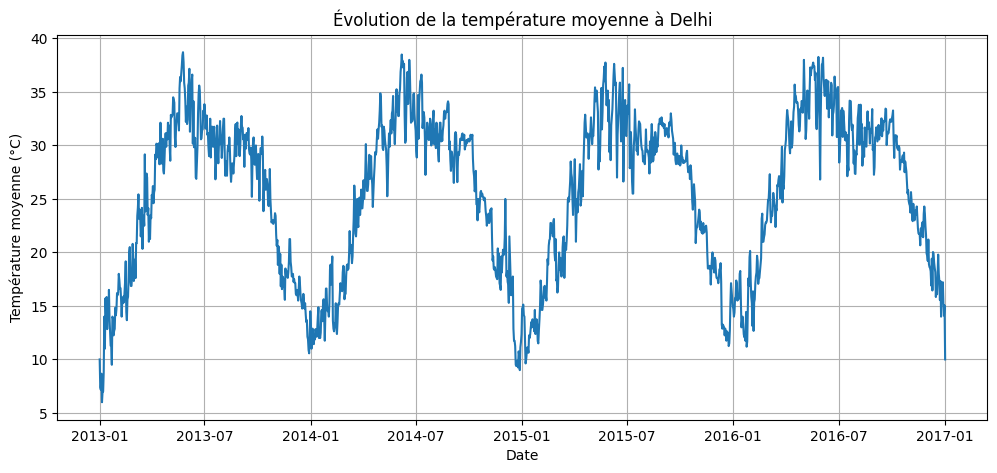

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
# 1. Chargement des données
df = pd.read_csv("..\data\DailyDelhiClimateTrain.csv", parse_dates=["date"])
df.set_index("date", inplace=True)

# Focus sur la température moyenne
temperature = df["meantemp"].interpolate()

# 🔍 Visualisation des tendances temporelles
import seaborn as sns
plt.figure(figsize=(12, 5))
sns.lineplot(data=temperature)
plt.title("Évolution de la température moyenne à Delhi")
plt.xlabel("Date")
plt.ylabel("Température moyenne (°C)")
plt.grid(True)
plt.show()


###  Entraînement du modèle

c:\Users\loris\MASI4-git\FrameworksMachineLearning\frameworks-machine-learning-project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


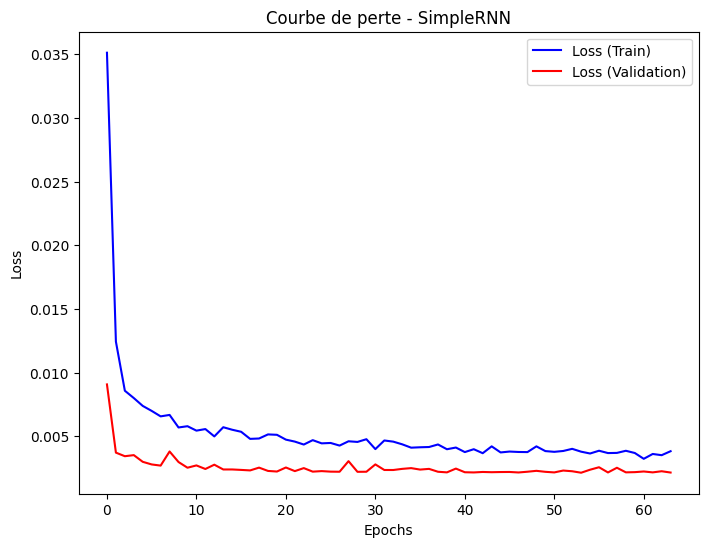

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
SimpleRNN - MSE: 2.45, MAE: 1.19, RMSE: 1.56


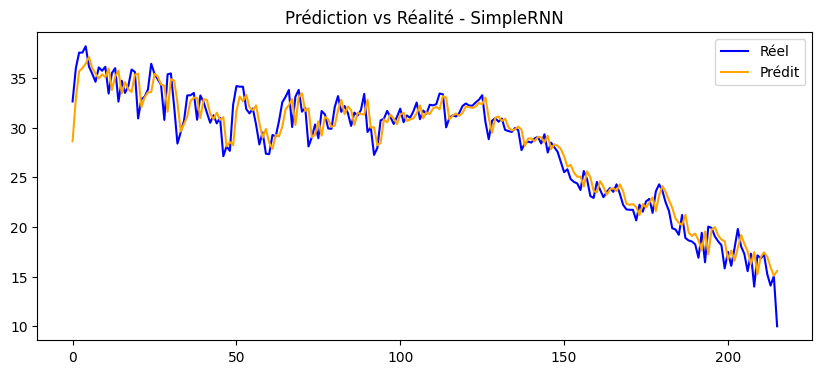

c:\Users\loris\MASI4-git\FrameworksMachineLearning\frameworks-machine-learning-project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


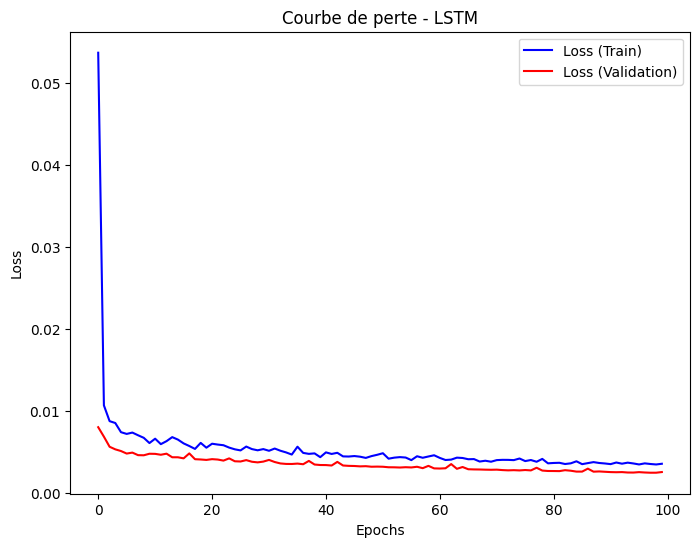

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
LSTM - MSE: 2.44, MAE: 1.21, RMSE: 1.56


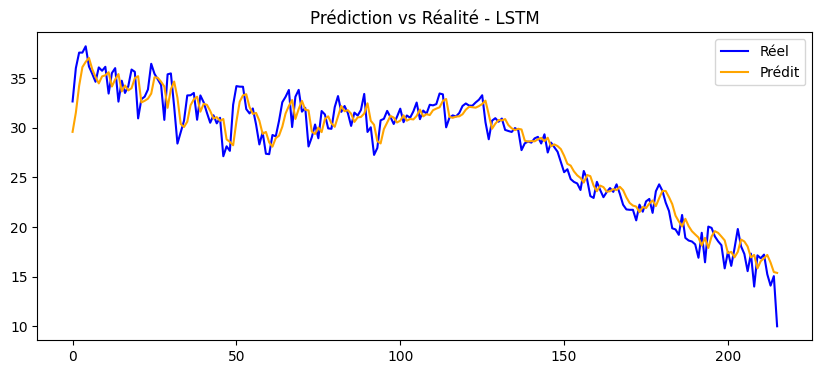

c:\Users\loris\MASI4-git\FrameworksMachineLearning\frameworks-machine-learning-project\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


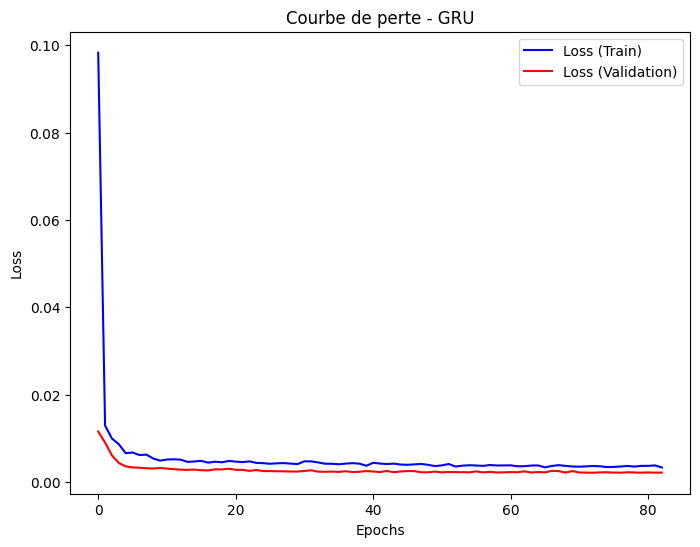

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
GRU - MSE: 2.37, MAE: 1.18, RMSE: 1.54


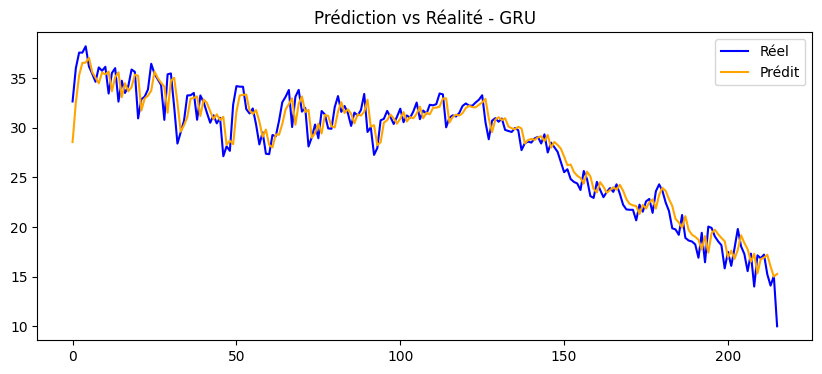

In [1]:
# Prédiction de Température Quotidienne avec RNN, LSTM, GRU

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# 1. Chargement des données
df = pd.read_csv("..\data\DailyDelhiClimateTrain.csv", parse_dates=["date"])
df.set_index("date", inplace=True)

# Focus sur la température moyenne
temperature = df["meantemp"].interpolate()

# 2. Normalisation
scaler = MinMaxScaler()
temperature_scaled = scaler.fit_transform(temperature.values.reshape(-1, 1))

# 3. Création des fenêtres temporelles
def create_windows(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_windows(temperature_scaled, window_size)

# 4. Split en train / val / test
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, y_train = X[:train_size], y[:train_size]
X_val, y_val = X[train_size:train_size+val_size], y[train_size:train_size+val_size]
X_test, y_test = X[train_size+val_size:], y[train_size+val_size:]

# 5. Fonction de création de modèles
def build_model(rnn_type="SimpleRNN", units=64, dropout=0.2):
    model = Sequential()
    if rnn_type == "SimpleRNN":
        model.add(SimpleRNN(units, input_shape=(window_size, 1)))
    elif rnn_type == "LSTM":
        model.add(LSTM(units, input_shape=(window_size, 1)))
    elif rnn_type == "GRU":
        model.add(GRU(units, input_shape=(window_size, 1)))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    return model

# 6. Fonction d'entraînement avec affichage de la courbe de perte
def compile_and_train(model, X_train, y_train, X_val, y_val):
    model.compile(loss='mse', optimizer=Adam(), metrics=['mae'])
    early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
    history = model.fit(
        X_train, y_train,
        validation_data=(X_val, y_val),
        epochs=100,
        batch_size=32,
        callbacks=[early_stop],
        verbose=0
    )

    # Affichage de la courbe de perte
    plt.figure(figsize=(8, 6))
    plt.plot(history.history['loss'], label='Loss (Train)', color='blue')
    plt.plot(history.history['val_loss'], label='Loss (Validation)', color='red')
    plt.title(f'Courbe de perte - {model.name}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    return model, history

# 7. Fonction d'évaluation avec graphiques de prédictions
def evaluate_model(model, X_test, y_test, name):
    y_pred = model.predict(X_test)
    y_pred_inv = scaler.inverse_transform(y_pred)
    y_test_inv = scaler.inverse_transform(y_test)

    # Calcul des métriques
    mse = mean_squared_error(y_test_inv, y_pred_inv)
    mae = mean_absolute_error(y_test_inv, y_pred_inv)
    rmse = np.sqrt(mse)

    print(f"{name} - MSE: {mse:.2f}, MAE: {mae:.2f}, RMSE: {rmse:.2f}")

    # Graphique des prédictions vs Réalité
    plt.figure(figsize=(10, 4))
    plt.plot(y_test_inv, label="Réel", color='blue')
    plt.plot(y_pred_inv, label="Prédit", color='orange')
    plt.legend()
    plt.title(f"Prédiction vs Réalité - {name}")
    plt.show()

# 8. Entraînement et évaluation des modèles
for rnn_type in ["SimpleRNN", "LSTM", "GRU"]:
    model = build_model(rnn_type)
    model.name = rnn_type  # Nom du modèle pour l'affichage
    model, history = compile_and_train(model, X_train, y_train, X_val, y_val)
    evaluate_model(model, X_test, y_test, rnn_type)


### Prédiction de la prochaine température

In [2]:
# 1. Préparer les données pour la prédiction
last_window = temperature_scaled[-window_size:].reshape(1, window_size, 1)

# 2. Faire une prédiction
predicted_temperature_scaled = model.predict(last_window)

# 3. Inverser la normalisation pour obtenir la température prédite dans les unités originales
predicted_temperature = scaler.inverse_transform(predicted_temperature_scaled)

# Afficher la température prédite pour le jour suivant
print(f"Température prédite pour le jour suivant : {predicted_temperature[0][0]:.2f}°C")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
Température prédite pour le jour suivant : 12.18°C


### Prédiction des températures pour les 7 jours suivant

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 92ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
        Date  Prédiction (Température)
0 2017-01-02                 12.175431
1 2017-01-03                 12.432004
2 2017-01-04                 12.568954
3 2017-01-05                 12.672009
4 2017-01-06                 12.773869
5 2017-01-07                 12.883889
6 2017-01-08                 13.002807


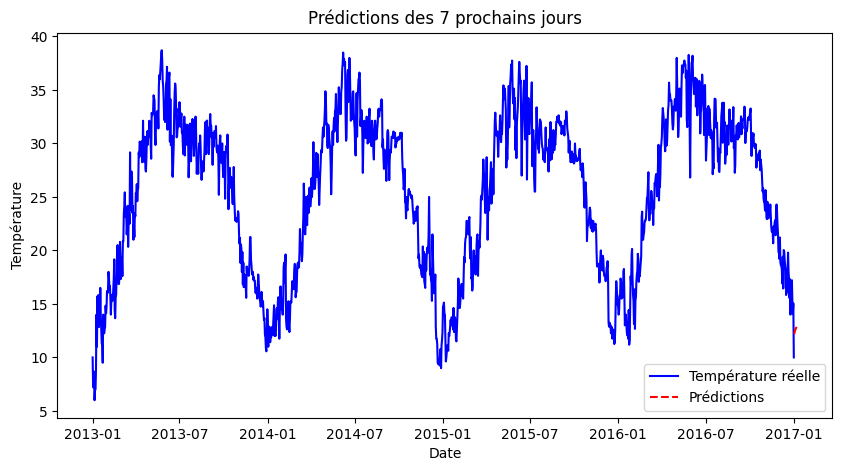

In [3]:
import pandas as pd

# Prédire les 7 prochains jours
predictions = []
current_input = temperature_scaled[-window_size:].reshape(1, window_size, 1)

for _ in range(7):  # Prédire pour les 7 prochains jours
    # Prédire la température pour le jour suivant
    predicted_temperature_scaled = model.predict(current_input)
    
    # Inverser la normalisation
    predicted_temperature = scaler.inverse_transform(predicted_temperature_scaled)
    
    # Ajouter la prédiction à la liste des prédictions
    predictions.append(predicted_temperature[0][0])
    
    # Mettre à jour la séquence d'entrée pour inclure la prédiction du jour précédent
    current_input = np.append(current_input[:, 1:, :], predicted_temperature_scaled.reshape(1, 1, 1), axis=1)

# Créer des dates pour les 7 prochains jours (en prenant la dernière date des données et en y ajoutant 1 jour à chaque fois)
last_date = df.index[-1]
predicted_dates = pd.date_range(start=last_date, periods=8, freq='D')[1:]

# Organiser les prédictions sous forme de tableau
predictions_df = pd.DataFrame({
    'Date': predicted_dates,
    'Prédiction (Température)': predictions
})

# Afficher le tableau des prédictions
print(predictions_df)

# Tracer les prédictions sur un graphique
plt.figure(figsize=(10, 5))
plt.plot(df.index, df["meantemp"], label="Température réelle", color="blue")  # Données réelles
plt.plot(predicted_dates, predictions, label="Prédictions", color="red", linestyle="--")  # Prédictions
plt.title("Prédictions des 7 prochains jours")
plt.xlabel("Date")
plt.ylabel("Température")
plt.legend()
plt.show()

